In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import pickle
import argparse
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
import sys
import datetime
from pathlib import Path
import seaborn as sns
import time
from Bio import SeqIO
from torch.utils.data import DataLoader
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from config import *
import util.misc as utils
from models.nt_classifier import build as build_model
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
check_data_path = '/data01/giorgio/RNARNA-NT/dataset/external_dataset/check_predictions'
original_data_path = os.path.join(check_data_path, 'original_data', 'check_predictions')
embedding_dir = os.path.join(check_data_path, 'embeddings')

In [4]:
# Function to parse the content
def parse_fa_content(content):
    entries = content.strip().split('>')
    data = []
    for entry in entries:
        if entry:
            lines = entry.split('\n')
            id_query = lines[0]
            cdna = ''.join(lines[1:])
            data.append([id_query, cdna])
    return pd.DataFrame(data, columns=['id_query', 'cdna'])


with open(os.path.join(original_data_path, 'embeddings.fa'), 'r') as file:
    file_content = file.read()

# Parse the content and create the DataFrame
df_query = parse_fa_content(file_content)

In [5]:
# devo droppare tutti quelli che non iniziano per ens
df_query['ens_gene'] = df_query['id_query'].str.startswith('ENS')
df_query = df_query[df_query.ens_gene].reset_index(drop = True)
df_query = df_query.drop('ens_gene', axis = 1)

In [ ]:
#droppo quelli che gia ci sono
all_files = os.listdir(os.path.join(embedding_dir, '32'))
all_files = list(pd.Series(all_files).str.extractall('(.*)\.npy').reset_index()[0])
df_query = df_query[~df_query.id_query.isin(all_files)]

In [ ]:
df_query.to_csv(os.path.join(check_data_path, f'embedding_query.csv'), index = False)

In [7]:
def estimate_time_and_space(n_samples):
    #TIME
    minutes = 3219*n_samples/(228278)
    hours = minutes/60
    days = hours/24
    print('estimated # hours:', np.round(hours, 2))
    print('estimated # days:', np.round(days, 2))

    mb = 10.2*n_samples
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (pessimistic):', np.round(tb, 2))
    mb = 1995*n_samples/(300)
    gb = mb/1000
    tb = gb/1000
    print('estimated terabytes (realistic):', np.round(tb, 2))
estimate_time_and_space(df_query.shape[0])

estimated # hours: 149.15
estimated # days: 6.21
estimated terabytes (pessimistic): 6.47
estimated terabytes (realistic): 4.22


In [10]:
df_query['len_cdna'] = df_query.apply(lambda x: len(x.cdna), axis = 1)

<AxesSubplot:>

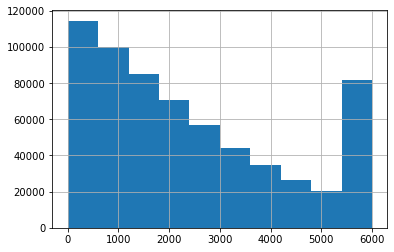

In [12]:
df_query['len_cdna'].hist()

In [41]:
df_genes = pd.read_csv(os.path.join(metadata_dir, f'embedding_query_paris.csv'))

In [44]:
df_genes['len_cdna'] = df_genes.apply(lambda x: len(x.cdna), axis =1)

<AxesSubplot:>

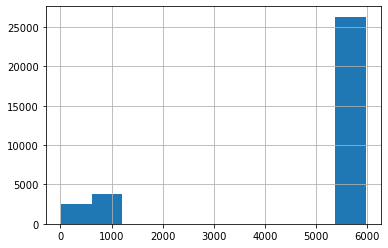

In [45]:
df_genes['len_cdna'].hist()

In [15]:
def read_and_concatenate_bed_files(directory):
    # List to store individual dataframes
    dataframes = []
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".bed"):
            file_path = os.path.join(directory, filename)
            # Read the .bed file into a dataframe
            df = pd.read_csv(file_path, sep='\t')
            
            # Check and rename columns if necessary
            if 'chrom_1' in df.columns and 'chrom_2' in df.columns:
                df = df.rename(columns={'chrom_1': 'emb_name_1', 'chrom_2': 'emb_name_2'})
            
            dataframes.append(df)
    
    # Concatenate all dataframes into one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    
    return concatenated_df

df = read_and_concatenate_bed_files(original_data_path)

In [18]:
df = df.drop('Unnamed: 0', axis = 1)

In [20]:
# devo droppare tutti quelli che non iniziano per ens
df['ens_gene'] = df['emb_name_1'].str.startswith('ENS')
df = df[df.ens_gene].reset_index(drop = True)
df = df.drop('ens_gene', axis = 1)

df['ens_gene'] = df['emb_name_2'].str.startswith('ENS')
df = df[df.ens_gene].reset_index(drop = True)
df = df.drop('ens_gene', axis = 1)

In [21]:
df.shape[0]

70102686